# Tangles of Personality Traits

In this notebook we demonstrate different aspects of the tangle-analysis. We will cover setting up a Survey object, the tangle search, order functions, the tree of tangles and more. We do so by giving a structural analysis of a questionnaire on the Big Five personality traits. We will explore the following problems: 

__Coherent groups of questions__  
We identify coherent structures within the questions. This lets us verify that there are five groups of related questions, called factors.

__Typical mindsets__  
We analyze the most typical ways of answering the questionnaire. These typical ways can be interpreted as mindsets of the participants.

__A tree-structure of mindsets__  
We structure typical mindsets by representing them as nodes in a tree — a tree of tangles.

__Intervals of typical answers__  
With a different setup of features, a tangle will give us, for each question, an interval in which answers to this question typically lie.

We will focus on the demonstration of techniques provided by the tangle library. While we will get some interesting insights into the considered survey, this is not an exhaustive survey analysis.

## 1. The Data

Let us start by having a look at our data. The [five factor model of personality](https://en.wikipedia.org/wiki/Big_Five_personality_traits) (also known as the OCEAN model or simply "Big Five") proposes that the personality of a person can be described, meaningfully, by how much each of the following five traits, called _factors_, apply to the person:
- __E__ for extraversion
- __N__ for neuroticism
- __A__ for agreeableness
- __C__ for conscientiousness
- __O__ for openness to experience

The data is provided in this repository, so you will not have to download it. We found the data ([here](https://openpsychometrics.org/_rawdata/): download link "BIG5"). Let's load the data into our notebook.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from src.utilities import load_big_five_data

X, var_names, var_labels, factors = load_big_five_data()

print(f"Number of participants: {X.shape[0]}")
print(f"Number of questions in the questionnaire: {X.shape[1]}")

Number of participants: 19384
Number of questions in the questionnaire: 50


There are ten questions for each of the five factors E, N, A, C and O ([details](https://ipip.ori.org/new_ipip-50-item-scale.htm)). 
Let's have a look at how the first participant rated the first ten statements, those measuring extraversion.

In [2]:
participant_rating = X[0]
pd.DataFrame(list(zip(var_labels, participant_rating))[:10], index=var_names[:10], columns=['Statement','Rating'])

,Statement,Rating
E1,I am the life of the party.,4
E2,I don't talk a lot.,2
E3,I feel comfortable around people.,5
E4,I keep in the background.,2
E5,I start conversations.,5
E6,I have little to say.,1
E7,I talk to a lot of different people at parties.,4
E8,I don't like to draw attention to myself.,3
E9,I don't mind being the center of attention.,5
E10,I am quiet around strangers.,1


Each line shows, from left to right,
- an abbreviation: E for the factor extraversion plus a statement index;
- the actual statement, as presented to the participants;
- how the first participant rated the statement, assigning an integer value in 1 (strong disagreement) to 5 (strong agreement). 

Looks like an extroverted participant!

Note, the statements E2, E4, E6, E8 and E10 are _negatively keyed_: a typical extroverted person will rate them low instead of high. 

The rating behaviour itself varies from participant to participant. Some answer in a more extreme way, preferring ratings of 1 and 5, others use more gentle ratings like 2 and 4. To avoid this affecting our analysis we __standardize the data__: for each participant we center its ratings at the participant's mean rating and scale them by the standard deviation of the participant's ratings.

In [3]:
from src.utilities import remove_rows_with_zero_std, standardize_ratings

X = remove_rows_with_zero_std(X) # we cannot divide by the standard deviation if it is zero
X = standardize_ratings(X)

The dataset, which previously had discrete values in $\{1, 2, 3, 4, 5\}$, now has continuous values. Let's see how this changed the answers of the first participant:

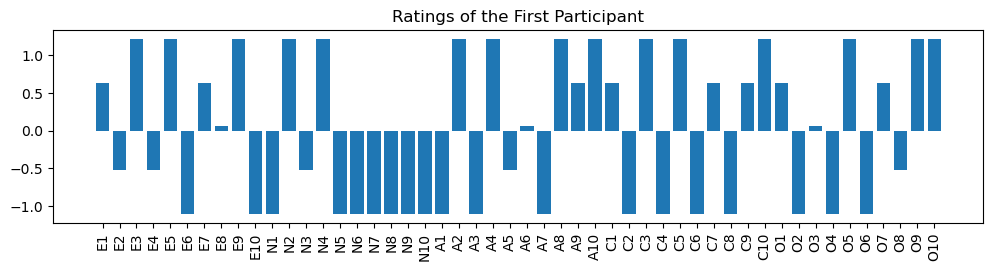

In [4]:
from src.utilities import styled_bar_plot
styled_bar_plot(X[0], 'Ratings of the First Participant', var_names)

We get a rough overview of how the first participant rated. 
Yet, it is hard to read because of the __negatively keyed statements__. For example, it would be nice to tell the participant's extraversion from the plot. 

To fix this we invert the ratings of all negatively keyed statements. 
Moreover, we tag the name of all inverted variables by changing, e.g., "E2" to "¬E2", and the same for the variable labels.
This will considerably improve interpretability.

In [5]:
from src.utilities import keying

keyed_X = X * np.asarray(keying)
keyed_var_names = np.asarray([l if neg==1 else f'¬{l}' for l, neg in zip(var_names, keying)])
keyed_var_labels = np.asarray([s if neg==1 else f'¬{s}' for s, neg in zip(var_labels, keying)])

Let us have a look at the answers of the first participant again.

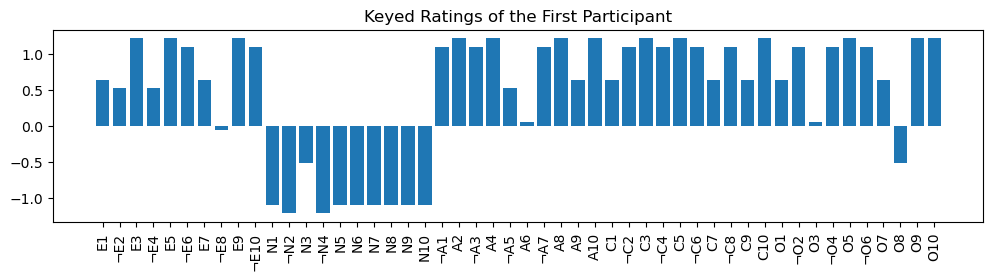

In [6]:
styled_bar_plot(keyed_X[0], 'Keyed Ratings of the First Participant', keyed_var_names)

This plot has a remarkably clear structure! It allows for an easy characterization:
- The first participant gives a high rating to most statements of the factors E, A, C, and O. Clearly, the participant seems to be an extroverted, agreeable, and conscientious person that is open to experience.
- Contrarily, all N statements are rated low, so the participant is not neurotic.

This seems like a plausible, even _typical_, combination of the factors. 
But did we just pick someone with such a clear profile by chance, or does this combination correspond to a typical mindset within all participants of the survey?
We will investigate this question in the later section on typical mindsets.

## 2. Surveys and Features

Our library provides a convenient helper object for preparing survey data for tangle analysis.
We prepare the data by initializing a `Survey` object and a `SurveyFeatureFactory` object. 

First, we set up the `Survey` object, which manages survey data and its corresponding metadata.

In [7]:
from tangles.convenience import Survey

survey = Survey(pd.DataFrame(keyed_X, columns = keyed_var_names))
survey.set_variable_labels(keyed_var_labels)
survey.set_variable_types('numerical')

survey.variable_info() # checking that everything is set up correctly

,id,name,type,label,valid_values,invalid_values,is_usable,num_valid_answers,num_unique_answers
E1,0,E1,numerical,I am the life of the party.,{},{},True,19360,10326
¬E2,1,¬E2,numerical,¬I don't talk a lot.,{},{},True,19360,10580
E3,2,E3,numerical,I feel comfortable around people.,{},{},True,19360,10196
¬E4,3,¬E4,numerical,¬I keep in the background.,{},{},True,19360,10275
E5,4,E5,numerical,I start conversations.,{},{},True,19360,10217
¬E6,5,¬E6,numerical,¬I have little to say.,{},{},True,19360,9975
E7,6,E7,numerical,I talk to a lot of different people at parties.,{},{},True,19360,10556
¬E8,7,¬E8,numerical,¬I don't like to draw attention to myself.,{},{},True,19360,10379
E9,8,E9,numerical,I don't mind being the center of attention.,{},{},True,19360,10607
¬E10,9,¬E10,numerical,¬I am quiet around strangers.,{},{},True,19360,10225


Everything looks just as expected. 

Now, we will __define the features__. 

For each statement we define a feature that contains all participants who "agree" with the statement. For our purposes, we say that a participant _agrees_ with a statement, if the participant's rating of the statement is greater than the median of all ratings of that statement.
Conversely, we say that the participant disagrees, if the rating is less than or equal to the median.

To implement this, we configure a `SurveyFeatureFactory`. Together with the `Survey` object, this will be all we need to search for tangles.

In [8]:
from tangles.convenience import SimpleSurveyFeatureFactory

# the invalid_values parameter is solely for compatibility with the feature factory 
def split_at_median(single_col, invalid_values):
    single_col = np.array(single_col)
    median = np.median(single_col, axis=0)
    feature = (single_col > median).astype(int) - (single_col <= median)
    metadata = np.empty(1, dtype=object)
    metadata[0] = ('>', median)
    return feature[..., np.newaxis], metadata

def create_median_feature_factory(survey):
    median_feature_factory = SimpleSurveyFeatureFactory(survey)
    median_feature_factory.numvar_func = split_at_median
    return median_feature_factory

Using the median to define the features is but one of many options. A different definition comes with a different interpretation of the features and, consequently, a different interpretation of the tangles we will find. 

The possibility to choose the definition of the features is an important tool in the tangle search process that opens up possibilities for the user to customise their analysis.

## 3. Verifying the Coherence of the Factors

We saw above that an extroverted person will probably rate all ten statements related to extraversion high (after reversing negatively keyed statements), indicating that all ten statements hold for this person. Thus, we suspect that if for a participant one of the E statements holds, typically all other E statements hold as well. We will verify that this is indeed the case.

### 3.1 The coherence of factor E (extraversion)

To do this, we search for tangles on the ten features corresponding to the statements E1, E2, ..., E10. Using `select_questions()`, we create a new survey that contains only E statements, and the `SurveyTangles.search()` method lets us search for tangles on the features created for those statements.

In [9]:
from tangles.convenience import SurveyTangles

E_questions = survey.select_questions(lambda variable: 'E' in variable.name)

agreement = 4000
tangles = SurveyTangles.search(E_questions, agreement, feature_factory=create_median_feature_factory(E_questions))

creating features... finished                                                                                                                         
[ tree height=10, number of tangles=3, limit=3207.0 ]: appending finished                                                                             


A brief word on the __agreement value__:  
As a rule of thumb, 10% of the data set size (in this case approximately 2000) is a good value to start with and will often yield multiple interpretable tangles.

So why do we use agreement 4000? Because we are interested in only the most typical combinations of statement ratings. That is, in terms of tangle terminology, the tangles with the highest agreement. By a little trial and error, agreement of 4000 turns out to be a good value, giving us the first complete tangles.

Let's inspect the tangles we found using the tangle matrix.

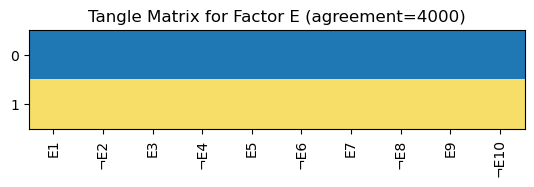

In [10]:
from src.utilities import plot_tangle_matrix

tangle_matrix = tangles.tangle_matrix()
plot_tangle_matrix(tangle_matrix, f'Tangle Matrix for Factor E (agreement={agreement})', E_questions.variable_info()['name']);

Row by row, the tangle matrix shows all tangles that were found. Focusing on one tangle, the column entries specify how the tangle orients the features identified by the labels of the columns. Here, a blue entry indicates disagreement to the statement and a yellow entry indicates agreement to the statement.

We find two very characteristic tangles. That's a great result! Let's interpret them:  
The two most typical ways to rate the statements of factor E is to 
- either agree to none of them  (tangle 0)
- or to agree to all of them (tangle 1).

Thus, we verified that the statements of factor E form a coherent structure within the dataset.

### 3.2 The coherence of all factors

Let's check the same for all five factors. 

In [11]:
agreements = {'E': 4000, 'N': 3500, 'A': 3000, 'C': 3000, 'O': 2600}

We found the agreement values as we did for the factor E above. 

The fact that for factor O the agreement needs to be chosen smaller than for factor E is interesting:  
We can think of the agreement value as a measure of how typical the tangle is: the fact that the O tangles have a lower agreement value than the E tangles indicates that agreeing or disagreeing to all O factors is less typical than agreeing or disagreeing to all E factors.

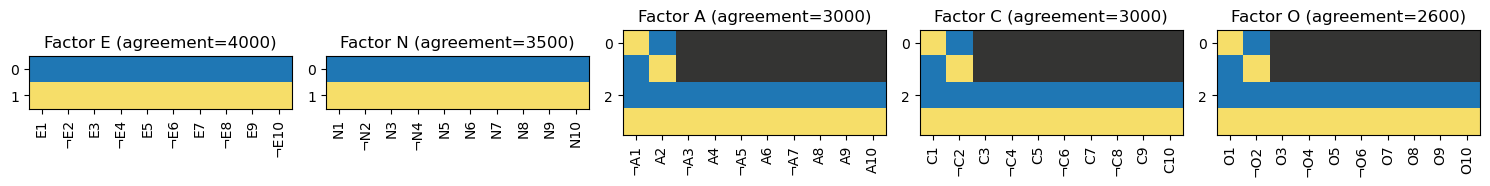

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(15,4))
for i, factor in enumerate(factors):
    questions_selection = survey.select_questions(lambda variable: factor in variable.name)
    feat_fac = create_median_feature_factory(questions_selection)
    agreement = agreements[factor]
    tangles = SurveyTangles.search(questions_selection, agreement, feature_factory=feat_fac, progress_callback=None)
    plot_tangle_matrix(tangles.tangle_matrix(), f'Factor {factor} (agreement={agreement})', 
                       questions_selection.variable_info()['name'], ax=axs[i])

fig.tight_layout()

Excellent, we can verify the coherence of all five factors.

What about the __incomplete tangles__ of factors A, C and O? In scenarios where we are working with an order function, incomplete tangles can be valuable for interpretation. Remember that the order function determines the order in which the tangle search tries to specify the potential features. Usually we trie to choose an order function such that the tangle search specifies potential features of more general statements first and of more specific statements last. Consequently, an incomplete tangle is a tangle that describes groups in more general terms, while a complete tangle goes into more details. We will introduce an order function later in this notebook.

We don't use an order function here, so the incomplete tangles aren't valuable for interpretation and we can ignore them.

However, we can explain the incomplete tangles to give some insights into the search process. Let's focus on the factor A:  
- Remember that, searching for tangles, we try to find specifications of the given ten potential features, such that the intersection of any three of the features is larger than the agreement value. The tangle search checks this feature by feature, in our case starting with A1 and A2 (going from left to right in the matrix). 
- The incomplete tangles specify the first two features A1 and A2 differently. Tangle 1 corresponds to a participant feeling little concern for others but at the same time being interested in people (and vice versa for tangle 0). This is a somewhat contradictory combination of statements, so the number of such participants is not large. Yet, it is still greater than the agreement value, so the tangle search doesn't stop trying to specify features. 
- In the next step, the tangle search checks triples of specifications of A1, A2 and A3 (i.e. it intersect the previous intersections of A1 and A2 with both specifications of A3). This leads to intersections that are smaller than the agreement value. As a result, the tangle search stops extending these tangles any further and the tangles are shown in the tangle matrix with only A1 and A2 specified.

## 4. Typical Mindsets <a id='typical_mindsets'></a> 


In the previous section, we searched tangles separately for the five factors E, N, A, C and O. Now, we will search for tangles on all factors at once. This will let us identify typical mindsets of the participants of the survey.

Again, we start with a relatively high agreement.

In [13]:
agreement = 1800
tangles = SurveyTangles.search(survey, agreement, feature_factory=create_median_feature_factory(survey))

creating features... finished                                                                                                                         
[ tree height=50, number of tangles=14, limit=1792.0 ]: appending finished                                                                            


As in the previous section, only the complete tangles are of interest because we don't use an order function yet.

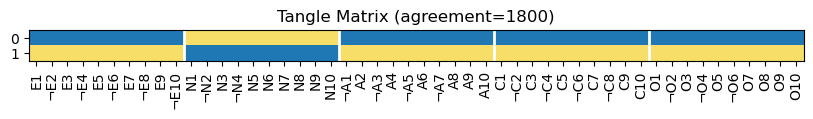

In [14]:
from src.utilities import plot_big5_tangle_matrix

plot_big5_tangle_matrix(tangles.tangle_matrix(), agreement, survey.variable_info()['name'])

Interesting! The two most common combinations of statements perfectly align with the factors, i.e. all statements within a factor are specified in the same way. This is not too surprising: we already saw this structure in the previous section.

What's new is that the most typical mindsets that are present in the participants are
- Tangle 1: people who are extroverted (E), agreeable (A), conscientious (C) and open for experience (O), but not neurotic (N)
- Tangle 0: people with the opposite personality traits

These mindsets follow an intuition for what personality traits typically appear together. For example, you wouldn't usually expect a person to be neurotic and extroverted at the same time.  

Using the `change_agreement()` method, we can lower the agreement value and see what new tangles will be found, without having to redo the calculations necessary for the higher agreement value in the previous search.

In [15]:
agreement = 1700
tangles.change_agreement(agreement, force_tree_update=True)

[ tree height=50, number of tangles=30, limit=1698.0 ]: sweep finished                                                                                


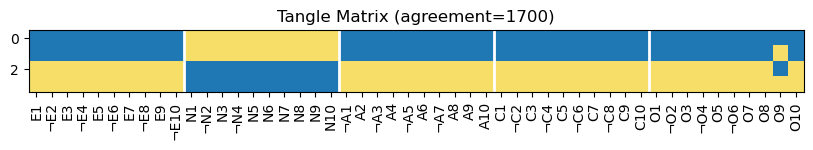

In [16]:
plot_big5_tangle_matrix(tangles.tangle_matrix(), agreement, survey.variable_info()['name'])

Two new tangles, both of them just varying statement O9 which is "I spend time reflecting on things.". This tells us that the ratings of the O9 statement do not align as consistently with the overall O factor ratings as they do for the other O statements. The reasons behind this can only be guessed but it may be because the statement is not very specific and rating the intensity or amount of time spend on reflecting things might be hard to judge objectively.

Note that we essentially found two tangles, plus two tangles that contain precisely the inverted features. 

Take, for example, the tangles in row 1 and 2: one might think that the combinations of factors in tangle 1 are as typically found in the survey data as the combination of factors in tangle 2. This might be, but is not necessarily the case: recall, that we defined the features by the median of a statement, which leads to very _balanced_ features (i.e. a feature and its inverse are of almost the same size). Consequently, whenever a tangle has high agreement, it is not surprising that its inverse tangle also has high agreement. How we define the features has a strong influence on the results of the tangle search.

Let us lower the agreement once more. 

In [17]:
agreement = 1648
tangles.change_agreement(agreement, force_tree_update=True)

[ tree height=50, number of tangles=50, limit=1647.0 ]: sweep finished                                                                                


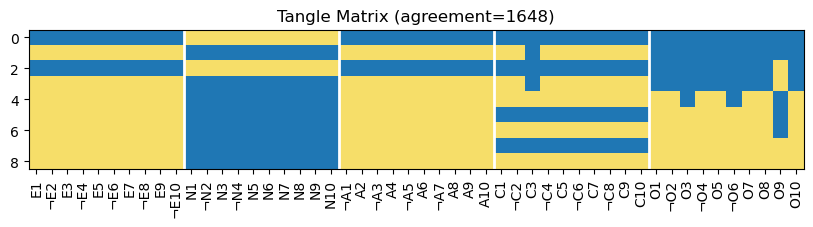

In [18]:
plot_big5_tangle_matrix(tangles.tangle_matrix(), agreement, survey.variable_info()['name'])

New tangles! Some tangles differ only in how O9 is specified, which makes the tangle matrix a bit harder to read. Yet, we can clearly make out two new typical mindsets:
- extroverted, agreeable and conscientious; but not neurotic and not open for experience
- extroverted, agreeable and open for experience; but not neurotic and not conscientious

Can we find more tangles that reveal typical combinations of factors if we lower the agreement value just a little more?

In [19]:
agreement = 1645
tangles.change_agreement(agreement, force_tree_update=True)

[ tree height=50, number of tangles=55, limit=1644.0 ]: sweep finished                                                                                


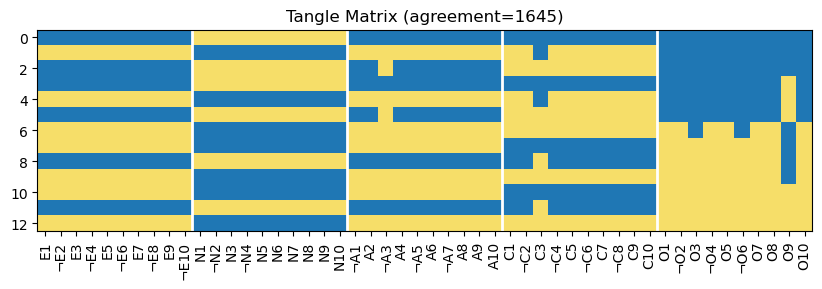

In [20]:
plot_big5_tangle_matrix(tangles.tangle_matrix(), agreement, survey.variable_info()['name'])

Yes. We pick out the tangles with newly appearing combinations:
- row at index 2: neurotic and conscientious; but not extroverted, not agreeable and not open for experience
- row at index 11: neurotic and open for experience; but not extroverted, not agreeable and not conscientious

Note that, for this agreement, not all factors are distinguishable. E.g. all tangles that indicate disagreement to the E statements also indicate agreement to the N statements and vice versa.

We stop decreasing the agreement at this point, but feel free to go on and play around with different agreement values.  
Note that at some point (try agreement 1500) the number of tangles increases drastically, making interpretations hard. Picking appropriate values for the agreement is crucial.

### Conclusion

We found the six most typical mindsets present in the data set. Let us get an overview and visualize the results in a simple picture, where each row shows a typical mindset (from the most typical one in the first row to the least typical one in the last row).

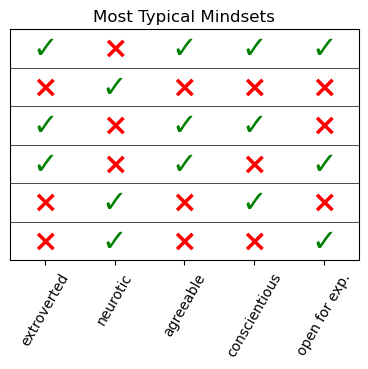

In [21]:
from src.utilities import plot_mindsets

typical_mindsets = np.asarray([[1,-1,1,1,1],
                               [-1,1,-1,-1,-1],
                               [1,-1,1,1,-1],
                               [1,-1,1,-1,1],
                               [-1,1,-1,1,-1],
                               [-1,1,-1,-1,1]])
plot_mindsets(typical_mindsets, 'Most Typical Mindsets')

If we have a closer look, we notice an interesting detail: the six mindsets we found can actually be described by only three mindsets and their inverses. Let's visualize them again but ordering them pairwise with their inverses.

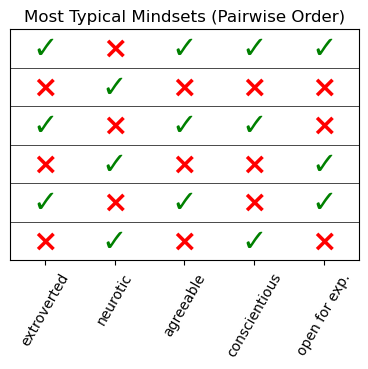

In [22]:
plot_mindsets(typical_mindsets[[0,1,2,5,3,4]], 'Most Typical Mindsets (Pairwise Order)')

## 5. A Tree Structure on Mindsets

In this section we will calculate a _tree of tangles (TOT)_, which will structure the tangles as nodes in a tree. Remember that tangles represent typical mindsets, so plotting the TOT lets us obtain a structure of typical mindsets in the data.

To obtain our goal we need to
- define an order function,
- search tangles,
- calculate a TOT for these tangles,
- and give the TOT a meaningful visualization.

### 5.1 Define an order function

To calculate a TOT we need a submodular __order function__ on the features. The definition of the order function has a great influence on what tangles will be found and how the tree of tangles will look like. Choosing and tweaking this definition is an important tool in the tangle workflow and can - and should - be utilised to obtain results that allow for the analysis of aspects of interest.

In this section we will implement the order function _(O1)_ from the [Tangles book](https://tangles-book.com). For a partition $\{A,B\}$ it is given by

\begin{align}
\sum_{a \in A} \sum_{b \in B} \sigma(a,b),
\end{align}

where $\sigma(a,b)$ is a function measuring the similarity of $a$ and $b$ and should be chosen such that it fits the problem at hand. In our specific application, we set $\sigma(a,b) = 1$, if $b$ is one of the $k$ most similar participants to $a$, and otherwise  $\sigma(a,b) = 0$. We will motivate this specific definition of $\sigma$ later.

__Overview__

Step by step we will
1. for any two participants $a$ and $b$, count on how many questions they agree;
2. for each participant $a$, determine the $k$ participants that agree with $a$ on the most questions, i.e. that are most similar to $a$;
3. define the order function _(O1)_ as described above.

__1. Count agreements on questions__

We count on how many questions two participants agree. Technically this is implemented using the Hamming distance.

The [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) is a tool that is usually used to describe the difference between two strings, counting the number of positions at which the symbols of the strings differ. We transfer this concept to the questionnaire data: given two participants we count the questions on which the participants _disagree_ (to calculate the similarity of participants this works just as well as counting their agreements).

To do so, we need a discretization of the ratings a participant gave, turning the ratings into binary answers: yes or no.

It is fortunate that we already have such a discretization! Turning the ratings into binary values is exactly what we did when we defined the features in the first section. Thus, we can calculate the distance matrix using the matrix of features.

In [23]:
from scipy.spatial.distance import pdist

feature_factory = create_median_feature_factory(survey)
features = feature_factory.create_features()[0]

hamming_distance = pdist(features, metric='hamming')

__2. Determine the most similar participants__

For each participant, we determine the $k$ participants that disagree on the fewest questions.

This can be done by calculating a $k$-nearest-neighbour graph. The graph is represented by an [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix), which can then be used as the similarity matrix containing at index $(i,j)$ the similarity $\sigma(i,j)$ of the $i$-th and the $j$-th participant. 

Experience has shown that considering only the $k$ most similar participants often is a good choice to define $\sigma$ with. One advantage of it is that we can easily analyze basic properties of the $k$-nearest-neighbour graph like its number of components or its average degree. Furthermore, we can adjust the graph to our needs by modifying its adjacency matrix.

In [24]:
from tangles.util.graph.similarity import k_nearest_neighbors

k = 2
k_nn_matrix = k_nearest_neighbors(hamming_distance, k=k)
similarity_matrix = k_nn_matrix + k_nn_matrix.T

We go for a __small value__ $k$, using $k=2$. Why?
- In many cases a small value (e.g. 4 or smaller) is enough to capture the most important structure in the data. Imagine a subset of participants that are very similar to each other. We want these participants to be part of a dense area in the $k$-nearest-neighbour graph and a small value for $k$ is sufficient to achieve this.
- Moreover, we benefit from the sparsity of the adjacency matrix as it leads to faster calculations in all following steps that involve the order function.

Also note the last line: it's a simple trick to obtain a symmetric matrix. This step is not obligatory, but the symmetry allows us to interpret the matrix as a similarity matrix, which simplifies the interpretation and analysis of the matrix.

Let's check some basic properties of the graph.

In [25]:
from scipy.sparse.csgraph import connected_components
print(f'#non-zero entries: {similarity_matrix.size}')
print(f"#connected components: {connected_components(similarity_matrix, directed=False, return_labels=False)}")

#non-zero entries: 66100
#connected components: 1


The graph is dense enough to be made up of only one component but still quite sparse (66,098 non-zero entries compared to a total 374,809,600 entries in the adjacency matrix).

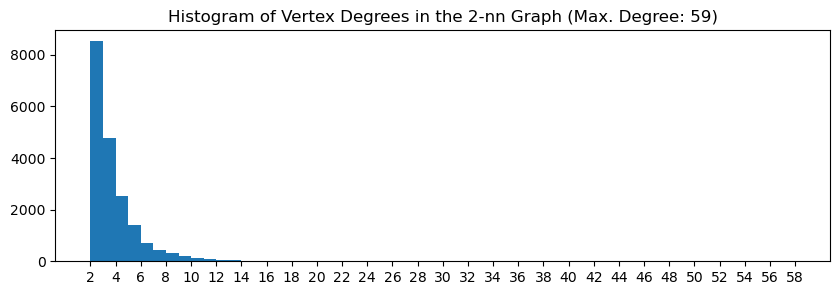

In [26]:
degrees = (similarity_matrix>0).sum(axis=1)
plt.figure(figsize=(10,3))
plt.hist(degrees, bins=range(degrees.min(), degrees.max()))
plt.xticks(ticks=range(degrees.min(), degrees.max(), 2))
plt.title(f"Histogram of Vertex Degrees in the {k}-nn Graph (Max. Degree: {degrees.max()})");

Most vertices are of degree 2. But while the the number of vertices of large degree quickly declines, there are vertices of degree up to 59.

__3. Define the order function__

Finally, we define the order function _(O1)_.

To do so, we use the `matrix_order()` function provided by the tangle library.

In [27]:
from tangles.util.matrix_order import matrix_order

def order_function(features):
    return matrix_order(-similarity_matrix, features)

Note that `order_function()` does not literately calculate the order function _(O1)_, but an order function that induces the same order on our features as _(O1)_ does. Thus, we can go with `order_function()`, which has a more efficient implementation, and achieve the same results in the following calculations.

Let's have a look at the orders it assigns to the 50 original features.

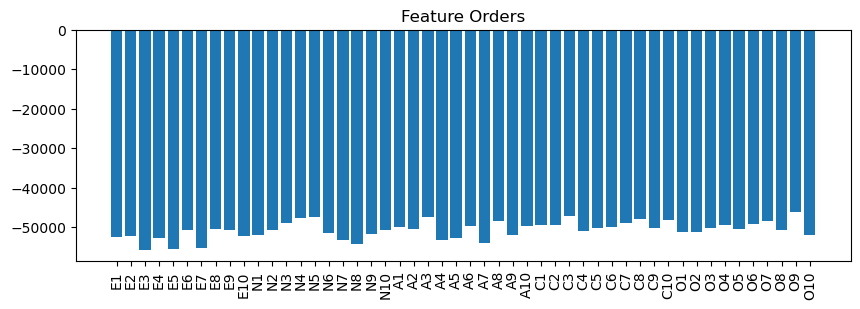

In [28]:
order = order_function(features)
plt.figure(figsize=(10,3))
plt.bar(range(len(order)), order)
plt.title(f'Feature Orders')
plt.xticks(range(len(var_names)), var_names, rotation=90);

In [29]:
print('Features, sorted lowest to highest order:')
print(var_names[np.argsort(order)])

Features, sorted lowest to highest order:
['E3' 'E5' 'E7' 'N8' 'A7' 'N7' 'A4' 'E4' 'A5' 'E1' 'E10' 'E2' 'A9' 'N1'
 'O10' 'N9' 'N6' 'O1' 'O2' 'C4' 'N10' 'E6' 'E9' 'N2' 'O8' 'O5' 'E8' 'A2'
 'C9' 'C5' 'O3' 'A1' 'C6' 'A10' 'A6' 'C1' 'C2' 'O4' 'O6' 'C7' 'N3' 'O7'
 'A8' 'C10' 'C8' 'N4' 'A3' 'N5' 'C3' 'O9']


While all factors have features of relatively low and of relatively high order, factor E has most features of low order and factors O and C have most features of high order.

What does this tell us? 
- For our order function, the order of a feature is high if it separates the participants within dense areas of the graph, whereas it is low if dense areas get separated to a lesser extend.
- In other words, a low order feature of factor E partitions the participants such that on average two similar (i.e. small Hamming distance) participants are more likely to be in the same part of the bipartition. Conversely, a factor O or factor C feature of high order has a stronger tendency to separate two similar participants.

The order of the features will have a recognisable impact on how the tangles in the TOT look like. We will address this effect later.

### 5.2 Search tangles

Using the `order_function()` that we just defined to specify the order of the features, let's search for tangles.
Note that we set the uncross parameter to True: this will add features that are logical combinations of the original features, called _corners_. These are necessary to be able to compute a TOT.
We call the process of adding corners _uncrossing_.

In [30]:
agreement = 500
tangles = SurveyTangles.search(survey, agreement, feature_factory=feature_factory, order=order_function, uncross=True)

creating features... finished                                                                                                                         
[ tree height=278, number of tangles=6, limit=498.0 ]: appending finished                                                                             


In [31]:
print(f'Total number of features in the search result: {len(tangles.feature_system)}')

Total number of features in the search result: 758


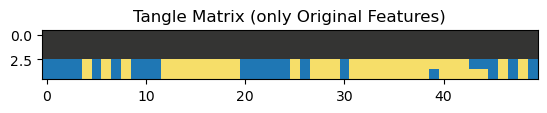

In [32]:
plot_tangle_matrix(tangles.tangle_matrix(False, False, False), 'Tangle Matrix (only Original Features)');

Let us address a property of the tangle matrix that might seem odd:  
The tangles in the upper part of the tangle matrix do not specify any of the original separations. However, this is not a problem, since uncrossing added features that are corners of the original features (and of previously added corners), i.e. they are logical combinations of the original features. The tangles in the upper part of the tangle matrix specify many of those corners, so these tangle nonetheless contain information about the statements corresponding to the original features.

### 5.3 Plot a tree of tangles

Now we calculate the tree of tangles.

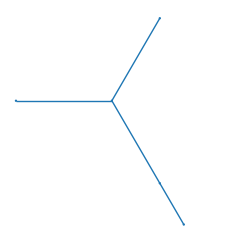

In [33]:
tot = tangles.sweep.create_tot(agreement)

from tangles.util.tree import plot_tree
fig, ax = plt.subplots(figsize=(3,3))
plot_tree(tot.nodes[0], ax=ax);

This was simple - but unfortunately there is not too much to make of it: it shows the overall structure, but we need more information about the tangles. Each node of the tree is a tangle, so we need to define a plot that visualises each of these tangles. In the above plot every node can then be replaced with this visualisation.

How to best visualize a tangle differs from application to application. In our case, we want the plot to show how much a tangle represents each of the five factors. More precisely, to each tangle we want to assign five values that indicate how the tangle relates to the five factors. We call this five values _factor weights_.

Given a tangle, to calculate its factor weights we will
1. calculate factor weights for each participant;
2. for all participants, calculate the tangle score with respect to the given tangle;
3. calculate the factor weights of the tangle, which we define as a score-weighted sum of the factor weights of all participants. 

__1. Factor weights for each participant__

We go with a simple approach: given a participants ratings to the 10 statements of a factor, the factor weight for this factor is the mean value of the ratings.

In [34]:
def calc_factor_weights_per_participant(features):
    return features @ np.kron(np.eye(5,dtype=int), np.ones((1,10))).T

factor_weights_per_participant = calc_factor_weights_per_participant(features)

__2. Tangle scores__

Given a tangle, the score is a measure of how much a participant is 'contained' within the tangle. There are different scoring algorithms implemented in the tangle library. We use the `soft_clustering_tuebingen` algorithm as it turns out to deliver good results for this use case.

In [35]:
from tangles.analysis import soft_clustering_tuebingen

tangle_matrix = tangles.sweep.tangle_matrix(only_initial_seps=False)
scores = soft_clustering_tuebingen(tangle_matrix, tangles.sweep.tree._sep_ids[:tangle_matrix.shape[1]], tangles.feature_system)

__3. Factor weights of a tangle__

Now, given a tangle we can calculate its factor weights as a score-weighted sum of all participants factor weights.

In [36]:
from src.radar_plot_util import soft_max

def calc_factor_weights_by_score_weighted_participants(scores, factor_weights_per_participant, tangle_idx, soft_max_scaling):
    soft_maxed_scores = soft_max(scores[:,tangle_idx], scaling=soft_max_scaling)
    return np.sum(factor_weights_per_participant * soft_maxed_scores[:,np.newaxis], axis=0)

__Plotting factor weights__

What's left to implement is how to plot the factor weights of a tangle.

In [37]:
from src.radar_plot_util import create_factor_weights_radar_plot

def plot_factor_weights_by_score_weighted_participants(node, ax, sweep, scores, factor_weights_per_participant, soft_max_scaling=10):
    factor_weights = calc_factor_weights_by_score_weighted_participants(scores, factor_weights_per_participant, node.tangle_idx, soft_max_scaling)
    # use the location size as plot title
    if len(node.star[0]) != 0:
        location_size = np.sum(sweep.sep_sys.compute_infimum(*node.star) == 1)
    else:
        location_size = ''
    create_factor_weights_radar_plot(ax, factor_weights, title=f'{location_size}')

Note that the bigger part of the code that is responsible for the plotting of the factor weights is hidden in the imports. This is mostly matplotlib setup and not interesting when getting to know tangles so we do not recommend to dig into this code.

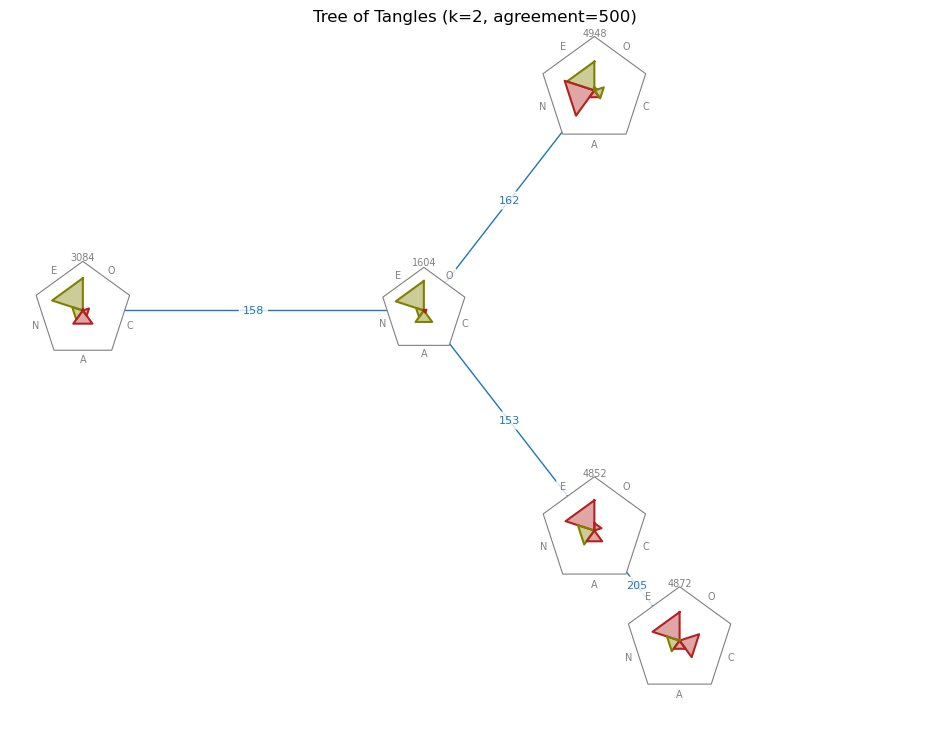

In [38]:
from src.radar_plot import radar_factory
from src.radar_plot_util import node_sizes_by_location_sizes, efficient_distinguisher_tree_level_annotation

# matplotlib setup: we need to register a new axes projection type
radar_factory(5, frame='polygon')

node_sizes = node_sizes_by_location_sizes(tangles.sweep, tot, (0.12, 0.12), lambda x : np.power(x,1/5))
fig, ax = plt.subplots(figsize=(12,9))
plot_tree(tot.nodes[0],
          ax=ax,
          plot_node=lambda node, ax: plot_factor_weights_by_score_weighted_participants(node, ax, tangles.sweep, scores, factor_weights_per_participant), 
          node_size=node_sizes,
          ax_projection='radar',
          plot_edge_annotation=efficient_distinguisher_tree_level_annotation(tangles.sweep, tot))
ax.set_title(f'Tree of Tangles (k={2}, agreement={agreement})');

A green triangle indicates a positive and a red triangle indicates a negative factor weight. The size of the triangle indicates the magnitude of the factor weight. Furthermore, the title of each node tells us the size of the _location_ of that tangle (i.e. the size of the intersection of all efficient distinguishers associated with the adjacent edges).

The blue annotation at each edge shows the tree level at which the efficient distinguisher corresponding to the edge appears in the _tangle search tree_. The _tangle search tree_ contains the features of lowest order at its lowest levels, so a small tree level comes with a small feature order, and vice versa. Usually, we think of features at a smaller tree level (that is, of lower order) as features that split the set of participants by a more general criterion. Conversely, features at a higher tree level correspond to more specific criteria.

The TOT gives an overview over all tangles found. There is a subtree that contains different facets of mindsets of (more or less) extroverted participants, while another subtree contains that of introverted participants.

## 6. Typical Ranges of Ratings

In the previous sections we have defined one potential feature for each statement. For each participant, this gave us a true/false classification for each of the 50 statements. Now, we will follow a more fine-grained approach. For each statement $q$ we create not one but four potential features:
- $s_1=\{q \geq 2\}$
- $s_2=\{q \geq 3\}$
- $s_3=\{q \geq 4\}$
- $s_4=\{q \geq 5\}$

Given a tangle that specifies a subset of these potential features we can derive an __interval of typical ratings__ of $q$. Let's have a look at an example. Assume a tangle contains $s_2$ and $s_{4}^C$. Participants that are in both $s_2$ and $s_{4}^C$ gave $q$ a rating of at least 3, but not 5 or higher, resulting in the rating interval $q \in [3,4]$. 

### 6.1 Features at thresholds

Analysing intervals of typical answers is a great way to do tangle analysis; not only for this survey, but for surveys containing ordinal variables in general.
For that reason, users of the tangle library are provided with this functionality, and all what's left to do is to properly set up a `Survey` object!

Given this `Survey` object, the tangle library is able to
- automatically create the necessary features (features like $s_i$ above), and
- automatically calculate typical intervals of values, given the tangle search results.

We start fresh and load the data from file again. In this example, we limit ourselves to the __subset of N-factor (neuroticism) statements__. 

In [39]:
X, var_names, var_labels, factors = load_big_five_data()
X = remove_rows_with_zero_std(X)

N_idxs = range(10,20)
X_N = X[:,N_idxs]
var_names_N = var_names[N_idxs]
var_labels_N = var_labels[N_idxs]

Let's set up a `Survey` object containing the data of N statements.

In [40]:
survey_N = Survey(pd.DataFrame(X[:,N_idxs], columns = var_names_N))
survey_N.set_variable_labels(var_labels_N)
survey_N.set_variable_types('ordinal')

We need to take care of the negatively keyed statements N2 and N4. Just like we did for the data in the previous section, we tag the name and the label of all negatively keyed variables with a "¬" and reverse the rating scale. This way, for negatively keyed statements, 1 to 5 becomes 5 to 1. The method `replace_variable_values()` is a convenient way to do this.

In [41]:
from src.utilities import keying_N

keyed_var_names_N = np.asarray([l if neg==1 else f'¬{l}' for l, neg in zip(var_names_N, keying_N)])
keyed_var_labels_N = np.asarray([s if neg==1 else f'¬{s}' for s, neg in zip(var_labels_N, keying_N)])

survey_N.set_variable_names(keyed_var_names_N)
survey_N.set_variable_labels(keyed_var_labels_N)
survey_N.replace_variable_values(keyed_var_names_N[keying_N==-1], {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}, suppress_check_var_warning=True)

Let's complete the survey setup and check the `variable_info()`.

In [42]:
survey_N.guess_variable_value_lists(mark_added_labels=False)
survey_N.variable_info()

,id,name,type,label,valid_values,invalid_values,is_usable,num_valid_answers,num_unique_answers
N1,0,N1,ordinal,I get stressed out easily.,"{1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}",{},True,19360,5
¬N2,1,¬N2,ordinal,¬I am relaxed most of the time.,"{1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}",{},True,19360,5
N3,2,N3,ordinal,I worry about things.,"{1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}",{},True,19360,5
¬N4,3,¬N4,ordinal,¬I seldom feel blue.,"{1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}",{},True,19360,5
N5,4,N5,ordinal,I am easily disturbed.,"{1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}",{},True,19360,5
N6,5,N6,ordinal,I get upset easily.,"{1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}",{},True,19360,5
N7,6,N7,ordinal,I change my mood a lot.,"{1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}",{},True,19360,5
N8,7,N8,ordinal,I have frequent mood swings.,"{1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}",{},True,19360,5
N9,8,N9,ordinal,I get irritated easily.,"{1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}",{},True,19360,5
N10,9,N10,ordinal,I often feel blue.,"{1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}",{},True,19360,5


Great, the survey is ready to go.

### 6.2 Feature Order: Prefer Balanced Features

Next, we define an order function. Our goal is to favour balanced features (that is, features that split the set of participants into two roughly equally sized subsets) over unbalanced features. Thus, balanced features should get a low order assigned to and unbalanced features should get a high order assigned to.

To achieve this, we use the __negated discrete entropy__:
- Given a feature, the discrete entropy is large if the feature is very balanced and it is small if the feature is very unbalanced.
- However, we want balanced features to get a low order, so we negate the discrete entropy.

In [43]:
from tangles.util.entropy import entropy

def order_function(features):
    return -entropy(features)

To see that this choice for the order function makes sense, let's focus on the features $s_1, ..., s_4$ of a single statement. Specifying the most balanced features first, we decide if the interval is in the lower or in the upper range of the rating scale (w.r.t. the median of the ratings). Then, proceeding with less and less balanced features we gradually refine the interval.

We plot the orders to get a feeling for how the intervals will get composed of the specified features.

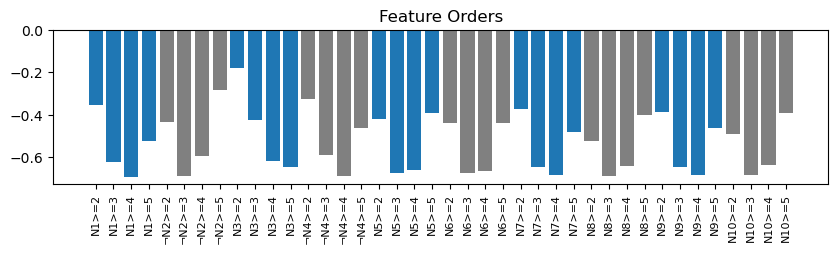

In [44]:
features, metadata = SimpleSurveyFeatureFactory(survey_N).create_features()

fig, ax = plt.subplots(figsize=(10,2))
ax.bar(range(features.shape[1]), order_function(features), color=(['tab:blue']*4+['grey']*4)*features.shape[1])
ax.set_title(f'Feature Orders')
ax.set_xticks(range(features.shape[1]), [''.join(map(str, m)) for m in metadata], fontsize=8, rotation=90);

First specifying the features with the lowest order and then adding more and more features will narrow the intervals described by the tangle.

Note that for most statements there exists a feature with relatively low order as well as a feature with relatively high order. Thus, when searching for tangles, the statements will get added in a "mixed" manner, narrowing the ten intervals roughly uniformly.

### 6.3 Interval tangles

Now, let's search for tangles and have a look at the tangle matrix.

In [45]:
agreement = 1500
tangles = SurveyTangles.search(survey_N, agreement, order=order_function)

creating features... finished                                                                                                                         
computing orders... finished                                                                                                                          
[ tree height=40, number of tangles=15, limit=1487.0 ]: appending finished                                                                            


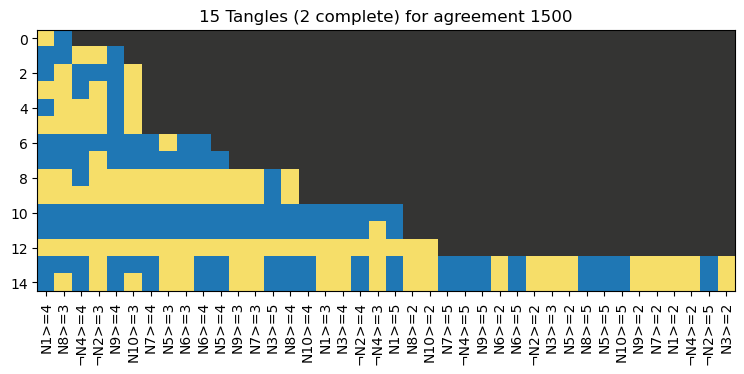

In [46]:
tangle_matrix = tangles.tangle_matrix(False, False, False)
plot_tangle_matrix(tangle_matrix, 
                   f'{tangle_matrix.shape[0]} Tangles ({np.sum(np.sum(np.abs(tangle_matrix), axis=1)==len(tangles.feature_system))} complete) for agreement {agreement}',
                   [''.join(map(str, m[0].info)) for m in tangles.ordered_metadata()],
                   ax = plt.subplots(figsize=(9,4))[1]);

We will not have a closer look the first eight tangles, as they are to unspecific and will not yield interesting intervals. Let's visualise the intervals of the remaining tangles.

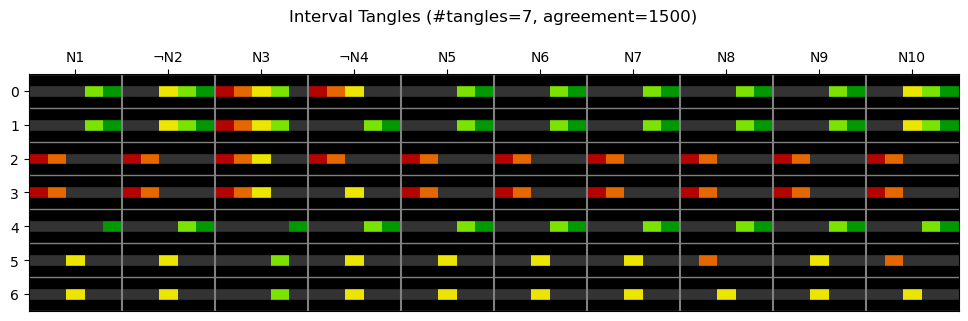

In [47]:
from src.rating_interval_util import plot_typical_answers

plot_typical_answers(tangles.typical_answers(insert_labels=False).iloc[8:], agreement, survey_N.data.columns)

Each entry in the plot shows an interval, e.g. N1 in tangle 0 depicts $[4,5]$.

When interpreting the results, keep in mind that the rating scale of the negatively keyed statements N2 and N4 is reversed. Here is a look-up table for the N statements: 

| N1                         | N2                              | N3                    | N4                  | N5                     | N6                  | N7                      | N8                           | N9                      | N10                |
|----------------------------|--------------------------------|-----------------------|---------------------|------------------------|---------------------|-------------------------|------------------------------|-------------------------|--------------------|
| <sub>I get stressed out easily.<sub> | <sub>I am relaxed most of the time.<sub> | <sub>I worry about things.<sub> | <sub>I seldom feel blue.<sub> | <sub>I am easily disturbed.<sub> | <sub>I get upset easily.<sub> | <sub>I change my mood a lot.<sub> | <sub>I have frequent mood swings.<sub> | <sub>I get irritated easily.<sub> | <sub>I often feel blue.<sub> |

We can recognize three groups of tangles:
1) __Tangles 5, 6:__ These tangles don't consist of intervals, but of a single value for each statement. Interestingly, moderate ratings are the most common way to rate the N statements. 
2) __Tangles 2, 3:__ We see two typical types of participants that __don't__ have a __neurotic__ tendency.
    - Tangle 2 is straightforward. All statements get a low rating. 
    - Tangle 3 represents participants that don't have typical neurotic character traits, but feel blue from time to time.   
3) __Tangles 0, 1, 4:__ We see the two most typical ways of how participants with a __neurotic__ tendency rate the statements.
    - Tangle 4 is straightforward.
    - Tangle 1 represents participants that are neurotic, but don't necessarily worry to much about things.
    - Tangle 0 is similar, but additionally this facet captures participants that feel blue less often than most participants with a neurotic tendency. 
    
Note a strange detail concerning tangle 0: While ¬N4 has a low to medium rating, N10, which can be see as an equivalent of ¬N4, has a medium to high rating. It may be interesting to investigate further into the relation of ¬N4 and N10 ratings!

Finally, two notes on this result:  
- The choice of feature order has a great influence on the results. Playing around with different feature orders is a nice way to get a feeling for the data and to better understand the tangle search process.
- Moreover, to get a valuable interpretation we choose a specific viewpoint on our data, namely, we only have a look at the N statements. Our experiments showed that if we instead look at the statements of one of the other four factors, the interval tangles may not reveal as much structural information as they do for N. The same holds if we consider all 50 statements at once: Firstly, interpretation is difficult because the large number of intervals can be overwhelming, and secondly, the vast majority of the found interval tangles differs just slightly, which makes most tangles uninteresting.

We encourage the user to play around with the setup of the tangle search to find other fruitful viewpoints on the data.